In [1]:
# Importing the libraries needed
import pandas as pd
import torch
import transformers
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertModel, DistilBertTokenizer

In [5]:
# Setting up the device for GPU usage

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [59]:
expert = pd.read_csv('/home/yagor/Рабочий стол/цифровой прорыв/all_data.csv') #
expert.head()

,Unnamed: 0.1,Unnamed: 0,Id,text,category,lvl,agent
0,0,0,1,Повышение кредитного рейтинга Акционерного об...,A,A,АКРА
1,1,1,6,Кредитный рейтинг ПАО «ФосАгро» (далее — Комп...,AAA,AAA,АКРА
2,2,2,10,Кредитный рейтинг ООО «МВМ» (далее — Компани...,A,A,АКРА
3,3,3,15,Кредитный рейтинг Акционерного общества «Сина...,A,A,АКРА
4,4,4,16,Кредитный рейтинг ПАО «М.видео» (далее — Груп...,A,A,АКРА


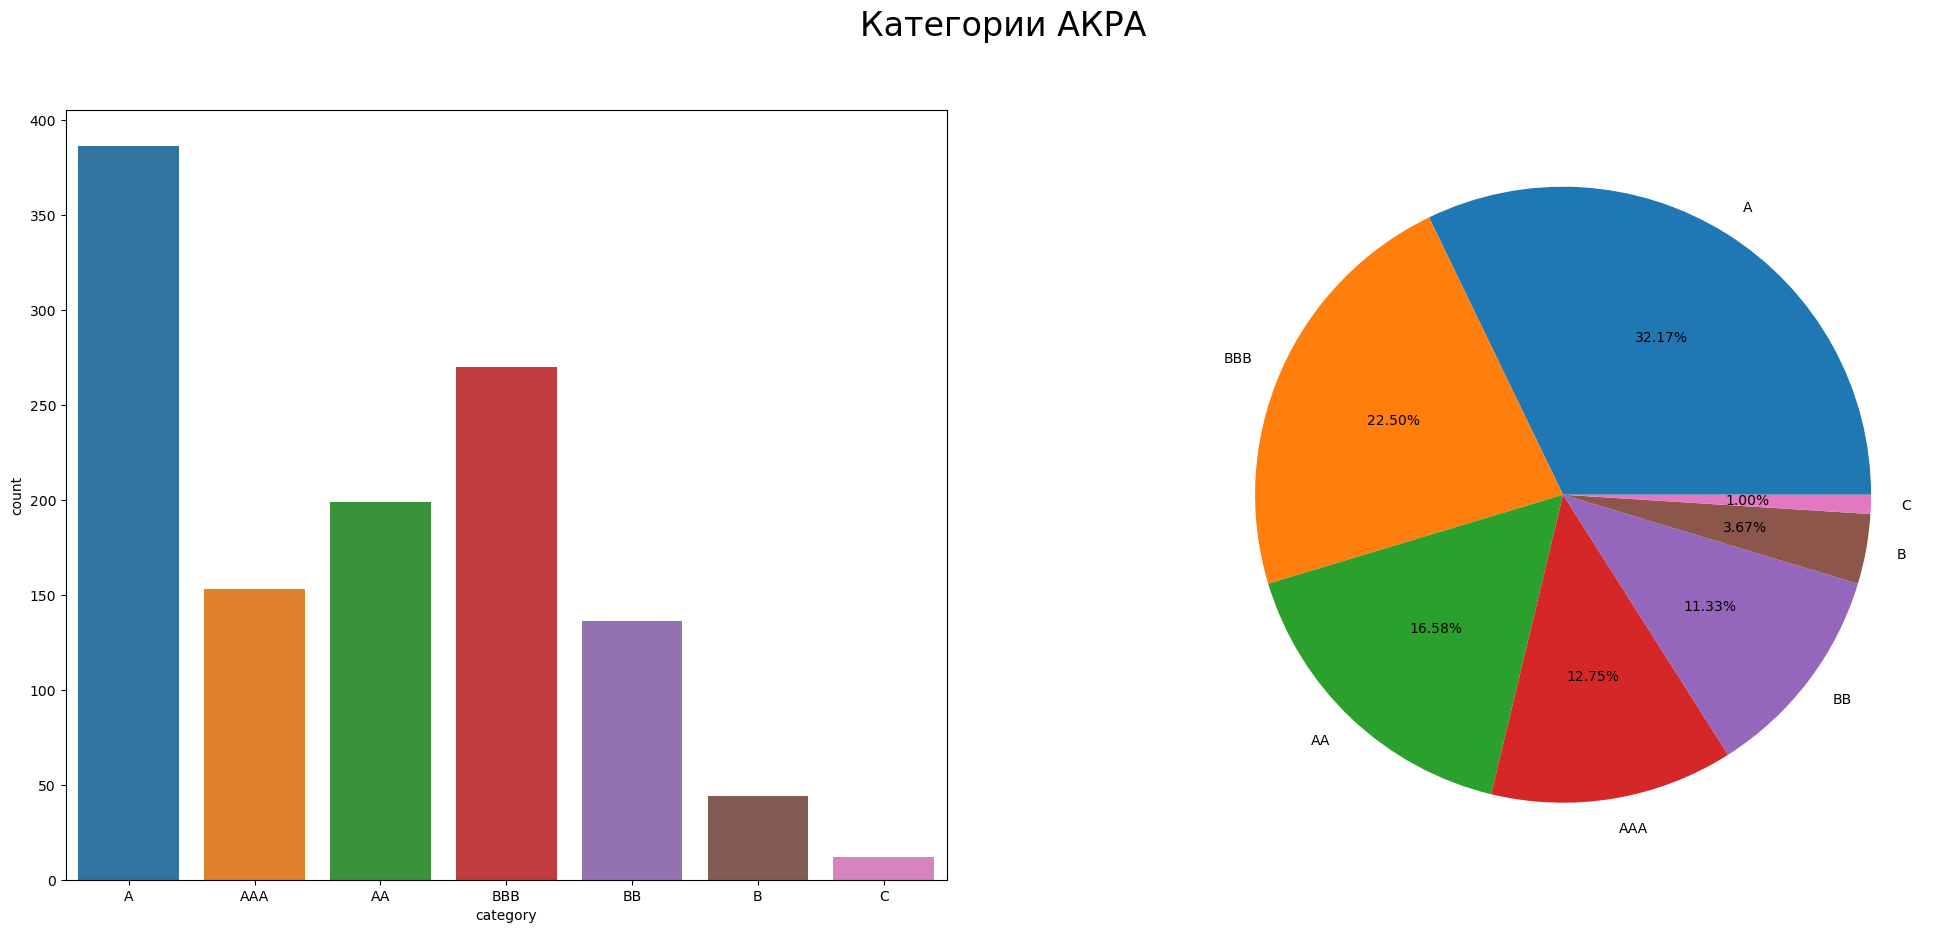

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(25, 10), dpi=100)
sns.countplot(x=expert['category'], ax=axes[0])
axes[1].pie(x=expert['category'].value_counts(),
            labels=expert['category'].value_counts().index,
            autopct='%1.2f%%',)
            #shadow=True,
            #explode=None,#(0.05, 0)
            #startangle=60)
fig.suptitle(f'Категории АКРА', fontsize=24)
plt.show()

In [61]:
reyt = ['AAA', 'AA', 'A', 'BBB', 'BB', 'B' ,'C']

all_reyt = []
adds = ['+', "", "-"]
for i in reyt:
    if i!='C' and i!='AAA':
        for j in adds:
            all_reyt.append(i+j)
    else:
        all_reyt.append(i)
# reyt = reyt[:len(reyt)-1] # класса C нет
print(reyt)
encode_dict = {reyt[-i]: i-1 for i in range(len(reyt)+1)}
print(encode_dict, sep=" ")

['AAA', 'AA', 'A', 'BBB', 'BB', 'B', 'C']
{'AAA': 6, 'C': 0, 'B': 1, 'BB': 2, 'BBB': 3, 'A': 4, 'AA': 5}


In [62]:
all_reyt_dict = {all_reyt[-i]: i-1 for i in range(len(encode_dict)+1)}
print(all_reyt_dict, sep=" ")

{'AAA': -1, 'C': 0, 'B-': 1, 'B': 2, 'B+': 3, 'BB-': 4, 'BB': 5, 'BB+': 6}


In [64]:
expert['ENCODE_CAT'] = expert['category'].apply(lambda x: encode_dict[x])

In [65]:
len(expert['ENCODE_CAT'].unique())

7

In [66]:
# expert['text_clean'] = expert['text'].replace(r'[^\w\s]',' ',regex=True).replace(r'\s+',' ',regex=True).str.lower()

In [67]:
import nltk
# from nltk.corpus import stopwords
# russian_stopwords = stopwords.words("russian")
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
stop = set(stopwords.words('russian'))

[nltk_data] Downloading package stopwords to /home/yagor/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/yagor/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/yagor/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/yagor/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
from transformers import BertTokenizerFast
MAX_LEN = 512
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 3
EPOCHS = 25
LEARNING_RATE = 1e-05
# tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased')
tokenizer = BertTokenizerFast.from_pretrained('blanchefort/rubert-base-cased-sentiment')
# model = AutoModelForSequenceClassification.from_pretrained('blanchefort/rubert-base-cased-sentiment', return_dict=True)

In [83]:
import numpy as np

In [84]:
np.random.randint(1, 100)

24

In [85]:
class Triage(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __getitem__(self, index):
        title = str(self.data.text[index])
        # title_split = title.split()
        # n_title = len(title_split)
        # start = max(0, np.random.randint(0, n_title-700))
        
        title = " ".join(title.split())
        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'targets': torch.tensor(self.data.ENCODE_CAT[index], dtype=torch.long)
        }

    def __len__(self):
        return self.len

In [86]:
train_size = 0.8
train_dataset=expert.sample(frac=train_size,random_state=200)
test_dataset=expert.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)


print("FULL Dataset: {}".format(expert.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = Triage(train_dataset, tokenizer, MAX_LEN)
testing_set = Triage(test_dataset, tokenizer, MAX_LEN)

FULL Dataset: (1200, 8)
TRAIN Dataset: (960, 8)
TEST Dataset: (240, 8)


In [87]:
train_dataset

,Unnamed: 0.1,Unnamed: 0,Id,text,category,lvl,agent,ENCODE_CAT
0,546,129,282,Эксперт РА» подтвердил кредитный рейтинг\nПАО ...,AA,AA+,Эксперт РА,5
1,842,425,854,«Эксперт РА» присвоил рейтинг компании «Селект...,A,A,Эксперт РА,4
2,678,261,529,«Эксперт РА» подтвердил рейтинг компании РУСАЛ...,A,A+,Эксперт РА,4
3,355,355,986,АКРА подтвердило кредитный рейтинг Государстве...,AA,AA,АКРА,5
4,397,397,1136,АКРА присвоило ООО «Группа Компаний ФСК» креди...,BBB,BBB+,АКРА,3
...,...,...,...,...,...,...,...,...
955,955,538,1047,«Эксперт РА» подтвердил рейтинг Башкирской сод...,A,A+,Эксперт РА,4
956,634,217,456,«Эксперт РА» присвоил рейтинг компании «Россий...,A,A,Эксперт РА,4
957,911,494,974,«Эксперт РА» присвоил рейтинг компании «Западн...,AA,AA,Эксперт РА,5
958,128,128,326,Кредитный рейтинг ООО «ТАМИ и КО» (далее — HE...,BBB,BBB+,АКРА,3


In [88]:
from torch.utils.data.sampler import WeightedRandomSampler
unique, counts = np.unique(train_dataset['ENCODE_CAT'], return_counts=True) 
# calcuate weight of each class 
class_weights = [1.0/c for c in counts] 
# # assign weight to each sample 
sample_weights = [class_weights[i] for i in train_dataset['ENCODE_CAT']] 
# # Create WeightedRandomSampler 
sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

In [89]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
               #'shuffle': True,
                'num_workers': 0,
                'sampler':sampler
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [3]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model.

class DistillBERTClass(torch.nn.Module):
    def __init__(self):
        super(DistillBERTClass, self).__init__()
        self.l1 = DistilBertModel.from_pretrained("blanchefort/rubert-base-cased-sentiment")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 7)

    def forward(self, input_ids, attention_mask):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [6]:
model = DistillBERTClass()
model.to(device)

You are using a model of type bert to instantiate a model of type distilbert. This is not supported for all configurations of models and can yield errors.
Some weights of DistilBertModel were not initialized from the model checkpoint at blanchefort/rubert-base-cased-sentiment and are newly initialized: ['transformer.layer.3.attention.v_lin.bias', 'transformer.layer.7.attention.v_lin.bias', 'transformer.layer.11.ffn.lin1.weight', 'transformer.layer.11.attention.k_lin.bias', 'transformer.layer.4.attention.q_lin.bias', 'transformer.layer.6.sa_layer_norm.bias', 'transformer.layer.2.sa_layer_norm.weight', 'transformer.layer.5.attention.v_lin.bias', 'transformer.layer.5.ffn.lin1.bias', 'transformer.layer.2.attention.v_lin.weight', 'transformer.layer.5.attention.out_lin.weight', 'transformer.layer.8.output_layer_norm.bias', 'transformer.layer.1.attention.out_lin.weight', 'transformer.layer.0.ffn.lin2.bias', 'transformer.layer.3.ffn.lin2.bias', 'transformer.layer.5.attention.q_lin.bias', 'tran

DistillBERTClass(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-11): 12 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linea

In [92]:
# Creating the loss function and optimizer
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [93]:
def calcuate_accu(big_idx, targets):
    n_correct = (big_idx==targets).sum().item()
    return n_correct

In [94]:
# Defining the training function on the 80% of the dataset for tuning the distilbert model

def train(epoch):
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model.train()
    for _,data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        outputs = model(ids, mask)
        loss = loss_function(outputs, targets)
        tr_loss += loss.item()
        big_val, big_idx = torch.max(outputs.data, dim=1)
        n_correct += calcuate_accu(big_idx, targets)

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)

        if _%5000==0:
            loss_step = tr_loss/nb_tr_steps
            accu_step = (n_correct*100)/nb_tr_examples
            print(f"Training Loss per 5000 steps: {loss_step}")
            print(f"Training Accuracy per 5000 steps: {accu_step}")

        optimizer.zero_grad()
        loss.backward()
        # # When using GPU
        optimizer.step()

    print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Training Loss Epoch: {epoch_loss}")
    print(f"Training Accuracy Epoch: {epoch_accu}")

    return

In [98]:
for epoch in range(EPOCHS):
    train(epoch)

OutOfMemoryError: CUDA out of memory. Tried to allocate 24.00 MiB (GPU 0; 11.75 GiB total capacity; 10.28 GiB already allocated; 54.62 MiB free; 10.35 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [96]:
def valid(model, testing_loader):
    model.eval()
    n_correct = 0; nb_tr_steps = 0; total = 0; tr_loss = 0
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            outputs = model(ids, mask).squeeze()
            loss = loss_function(outputs, targets)
            tr_loss += loss.item()
            big_val, big_idx = torch.max(outputs.data, dim=1)
            n_correct += calcuate_accu(big_idx, targets)

            nb_tr_steps += 1
            total+=targets.size(0)

            if _%5000==0:
                loss_step = tr_loss/nb_tr_steps
                accu_step = (n_correct*100)/total
                print(f"Validation Loss per 100 steps: {loss_step}")
                print(f"Validation Accuracy per 100 steps: {accu_step}")
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/total
    print(f"Validation Loss Epoch: {epoch_loss}")
    print(f"Validation Accuracy Epoch: {epoch_accu}")

    return epoch_accu


In [97]:
print('This is the validation section to print the accuracy and see how it performs')
print('Here we are leveraging on the dataloader crearted for the validation dataset, the approcah is using more of pytorch')

acc = valid(model, testing_loader)
print("Accuracy on test data = %0.2f%%" % acc)

This is the validation section to print the accuracy and see how it performs
Here we are leveraging on the dataloader crearted for the validation dataset, the approcah is using more of pytorch
Validation Loss per 100 steps: 1.5291386842727661
Validation Accuracy per 100 steps: 66.66666666666667
Validation Loss Epoch: 1.0391267236322164
Validation Accuracy Epoch: 64.58333333333333
Accuracy on test data = 64.58%


In [ ]:
from tqdm.notebook import tqdm
model.eval()
valid_loss = 0
valid_pred = []
valid_real = []
with torch.no_grad():
    for _, data in enumerate(tqdm(testing_loader, 0)):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)
        outputs = model(ids, mask).squeeze()

        # loss = output.loss
        # valid_loss += loss.item()
        big_val, big_idx = torch.max(outputs.data, dim=1)
        valid_real.append(targets.cpu().detach().numpy())

        valid_pred.append(big_idx.cpu().detach().numpy())

# val_loss_per_epoch.append(valid_loss / (step_num_e + 1))
valid_pred = np.concatenate(valid_pred)
valid_real = np.concatenate(valid_real)

  0%|          | 0/80 [00:00<?, ?it/s]

In [ ]:
from sklearn.metrics import classification_report
print('classifiation report')
print(classification_report(valid_pred, valid_real))

In [64]:
from sklearn.metrics import classification_report
print('classifiation report')
print(classification_report(valid_pred, valid_real))

classifiation report
              precision    recall  f1-score   support

           0       0.60      1.00      0.75         3
           1       0.25      0.18      0.21        11
           2       0.43      0.83      0.57        12
           3       0.77      0.62      0.68        81
           4       0.71      0.75      0.73        77
           5       0.79      0.74      0.76        35
           6       0.83      0.95      0.89        21

    accuracy                           0.70       240
   macro avg       0.63      0.73      0.66       240
weighted avg       0.72      0.70      0.70       240



In [ ]:
akra Accuracy on test data = 71.21%
all data Accuracy on test data = 71.25%
all data with delete punkt Accuracy on test data = 70.42%

In [99]:
!mkdir continue_model

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [100]:
output_model_file = './continue_model/pytorch_distilbert_news.bin'
output_vocab_file = './continue_model/vocab_distilbert_news.bin'

model_to_save = model
torch.save(model_to_save, output_model_file)
tokenizer.save_pretrained(output_vocab_file)

print('All files saved')
print('This tutorial is completed')

All files saved
This tutorial is completed


In [11]:
DistillBERTClass.load_state_dict('./continue_model/pytorch_distilbert_news.bin')

TypeError: load_state_dict() missing 1 required positional argument: 'state_dict'

In [8]:
model = DistillBERTClass.from_pretrained('./continue_model/pytorch_distilbert_news.bin')
tokenizer = BertTokenizerFast.from_pretrained('/continue_model/vocab_distilbert_news.bin')

AttributeError: type object 'DistillBERTClass' has no attribute 'from_pretrained'

In [19]:
import numpy as np
import torch.nn.functional as F

In [20]:
sample_text = "«Эксперт РА» присвоил кредитный рейтинг АО «Новосибирскэнергосбыт» на уровне <rating>   Москва,  10 марта 2023 г.  Рейтинговое агентство «Эксперт РА» присвоило  рейтинг кредитоспособности  нефинансовой компании   АО «Новосибирскэнергосбыт»   на уровне <rating>. Прогноз по рейтингу – стабильный.  ) АО «Новосибирскэнергосбыт»  (далее – компания) – обеспечивает энергоснабжение г. Новосибирска и  Новосибирской области и входит в десятку крупнейших энергетических сбытовых компаний  России. Основным видом деятельности Компании является покупка и реализация  электрической энергии потребителям (включая промышленные организации,  население, электросетевые компании региона), оказание комплекса услуг по разработке  энергосберегающих мероприятий.   Компания является  единственным гарантирующим поставщиком электроэнергии на территории  Новосибирской области и г. Новосибирска, занимая первое место среди  гарантирующих поставщиков в РФ с 2012-2022гг по мнению ассоциации НП Совет  рынка, по показателям эффективности работы с клиентами, своевременному  исполнению обязательства на оптовом рынке и лучшими показателями финансовой  устойчивости. За 9 мес  2022 года объем оказанных услуг по отпуску электрической энергии составил 9,6 млрд  кВт-ч (около 1,2% от объема электропотребления в России), что составляет более  95% доли рынка в регионе присутствия, значительную часть которых компания  обслуживает онлайн. На протяжении трех лет у компании отсутствую офисы по  приему потребителей, что позволяет компании обеспечить высокий уровень сбора  денежных средств и занимать первое место среди гарантирующих поставщиков,  сохраняя просроченную задолженность ниже среднерыночного уровня. В компании  действует программа cash-back (8-10% за своевременную оплату э/э), активно  применяются методы для взыскания просроченной дебиторской задолженности как:  отключение, взыскание через суд, лишение лицензии на деятельность, банкротство  должника, что приводит к высокой собираемости платежей в среднем на уровне 100%  за 2019-2022гг.    Агентство  оценивает устойчивость бизнеса к внешним шокам умеренно консервативно. В  регионах присутствия компания обеспечивает доступ к электроэнергии населению и  промышленным предприятиям, спрос на электроэнергию в меньшей степени зависит от  изменения тарифов и уровня цен на услуги, чем спрос на другие виды услуг и  товаров. Несмотря на исторические колебания энергопотребления потребления  компания демонстрировала устойчивый финансовый профиль на протяжении последних 3-5  лет, что поддерживалось вводом эталонного тарифа в сбытовом бизнесе и полной  цифровизацией компании. Однако, Агентство отмечает риск снижения  платежеспособности населения на фоне продолжения экономического спада в 2023 и  риски переключения ряда промышленных потребителей на прямые договора на оптовом  рынке электроэнергии и мощности, что может негативно сказаться на операционной  и финансовой деятельности компании."

In [21]:
# idx = np.random.choice(range(len(testing_set)))
input = tokenizer.encode_plus(
            " ".join(sample_text.split()),
            None,
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True
        )
ids = torch.tensor(input['input_ids'], dtype=torch.long).to(device, dtype = torch.long)
mask = torch.tensor(input['attention_mask'], dtype=torch.long).to(device, dtype = torch.long)

outputs = model(ids, mask).squeeze()
probs = F.softmax(outputs, dim=-1)

print("============= Actual Text =================== ")
print(sample_text)
print("============================================= ")
print("============= Tokenized Text ================ ")
print(input)
print("============================================= ")
print("Predicted Probabilities : {}".format(probs.detach().cpu().numpy()))

============= Actual Text =================== 
«Эксперт РА» присвоил кредитный рейтинг АО «Новосибирскэнергосбыт» на уровне <rating>   Москва,  10 марта 2023 г.  Рейтинговое агентство «Эксперт РА» присвоило  рейтинг кредитоспособности  нефинансовой компании   АО «Новосибирскэнергосбыт»   на уровне <rating>. Прогноз по рейтингу – стабильный.  ) АО «Новосибирскэнергосбыт»  (далее – компания) – обеспечивает энергоснабжение г. Новосибирска и  Новосибирской области и входит в десятку крупнейших энергетических сбытовых компаний  России. Основным видом деятельности Компании является покупка и реализация  электрической энергии потребителям (включая промышленные организации,  население, электросетевые компании региона), оказание комплекса услуг по разработке  энергосберегающих мероприятий.   Компания является  единственным гарантирующим поставщиком электроэнергии на территории  Новосибирской области и г. Новосибирска, занимая первое место среди  гарантирующих поставщиков в РФ с 2012-2022гг по м

In [ ]:
from captum.attr import IntegratedGradients
from captum.attr import visualization

ig = IntegratedGradients(predict)
attributions, delta = ig.attribute(X_text_vec, target=Y_test[100:105], return_convergence_delta=True)

viz_records = []
for i in range(5):
    tokenized_text = tokenizer(X_test_text[100+i]) ## Tokenize Text
    token_indexes = vocab(tokenized_text) ## Retrieve token indexes
    attributions_of_text = attributions[i][token_indexes] ## Retrieve attributions for tokens of text.
    viz_record = visualization.VisualizationDataRecord(attributions_of_text,
                                                       predicted_probs[i],
                                                       predicted_labels[i],
                                                       actual_labels[i],
                                                       predicted_labels[i],
                                                       attributions[i].sum(),
                                                       tokenized_text,
                                                       delta[i])
    viz_records.append(viz_record)